# The-A-Team Project - Proposal

This notebooks use AWS Athena to read the MIMiC III database stored in S3 buckets in Parquet files.
The CloudFormation template to download the database to the AWS Account S3 bucket and to setup a SageMaker notebook can be found here:
https://aws.amazon.com/blogs/big-data/perform-biomedical-informatics-without-a-database-using-mimic-iii-data-and-amazon-athena/

In [1]:
# Install OS dependencies.  This only needs to be run once for each new notebook instance.
!pip install PyAthena

In [2]:
from __future__ import print_function
from pyathena import connect
from pyathena.pandas.util import as_pandas


# Import libraries
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import boto3
from botocore.client import ClientError
# below is used to print out pretty pandas dataframes
from IPython.display import display, HTML
%matplotlib inline


s3 = boto3.resource('s3')
client = boto3.client("sts")
account_id = client.get_caller_identity()["Account"]
my_session = boto3.session.Session()
region = my_session.region_name
athena_query_results_bucket = 'aws-athena-query-results-'+account_id+'-'+region

try:
    s3.meta.client.head_bucket(Bucket=athena_query_results_bucket)
except ClientError:
    bucket = s3.create_bucket(Bucket=athena_query_results_bucket)
    print('Creating bucket '+athena_query_results_bucket)
cursor = connect(s3_staging_dir='s3://'+athena_query_results_bucket+'/athena/temp').cursor()


# The Glue database name of your MIMIC-III parquet data
gluedatabase="mimiciii"


The next dataframe contains the numberf of items found in chartevents table with the label of each item.

              itemid         count
count    6463.000000  6.463000e+03
mean    57798.857497  5.117012e+04
std     95116.437461  2.182052e+05
min         1.000000  1.000000e+00
25%      2414.500000  1.300000e+01
50%      5641.000000  8.600000e+01
75%      8498.500000  8.293000e+03
max    228451.000000  5.180809e+06


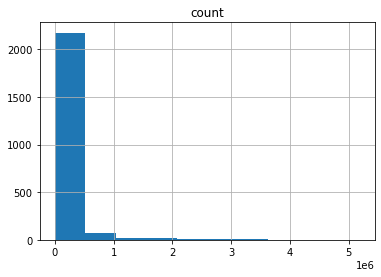

In [3]:
query='select i.itemid, i.label, count(c.row_id) count from mimiciii.chartevents as c left join mimiciii.d_items as i on c.itemid=i.itemid group by i.itemid, i.label order by i.label'
cursor.execute(query)
df = as_pandas(cursor)
df[df['count'] > 1000].hist(column='count')
bins = [0,500,1000,5000,15000,50000,250000,500000,800000,8000000]
df['count'].value_counts(bins=bins)
print (df.describe())

In [4]:
df

,itemid,label,count
0,1452,#1 chest tube irrig.,11
1,1,% Inspir. Time,6330
2,3226,%cool mist,1
3,3094,(L) FEM ART,10
4,3095,(R) FEM ART,12
...,...,...,...
6458,4755,zzzpH,1
6459,1711,zzzt Stim Thresh mA [Unit],17
6460,8497,zzzt Stim Thresh mA [Value],14
6461,4192,zzzzth in Centimeter,34


Exploratory query to get the date range of the events found in chartevents.

In [15]:
#query='select count(*) chartevents from mimiciii.chartevents where charttime > timestamp \'' + mindate.strftime('%Y-%m-%d %H:%M:%S') + '\''
query='select count(*) chartevents, MIN(CHARTTIME) mindate, max(CHARTTIME) maxdate from mimiciii.chartevents where not is_nan(VALUENUM)'
cursor.execute(query)
df = as_pandas(cursor)
df

,chartevents,mindate,maxdate
0,146504168,2100-06-07 20:00:00,2209-08-07 16:52:00


In [16]:
from datetime import timedelta

maxdate = pd.to_datetime(df['maxdate'][0])
mindate = maxdate - timedelta(hours=48)


Number of events recorded for each Patient.

In [17]:
query='select subject_id, count(*) events from mimiciii.chartevents where not is_nan(VALUENUM) group by subject_id'
cursor.execute(query)
print ("Query finished")
df = as_pandas(cursor)
df

Query finished


,subject_id,events
0,94484,1486
1,93647,12002
2,94356,478
3,94512,359
4,94072,1743
5,93325,4190
6,95540,599
7,95090,3308
8,94767,3046
9,94937,9099


In [18]:
df.to_csv("patientsinchartevents.csv")

Number of patients and mean, max, min and quartiles of events recorded for each patient.

In [20]:
print (df.describe())


         subject_id         events
count  46335.000000   46335.000000
mean   34496.773130    3161.846725
std    28358.498295    9065.680267
min        2.000000       1.000000
25%    12306.500000     521.000000
50%    24708.000000    1176.000000
75%    55648.500000    2941.000000
max    99999.000000  758554.000000


Filter and descriptive stats of chartevents that contain numerical values.

In [98]:
query='select i.itemid itemid, i.label, count(c.row_id) events from mimiciii.chartevents as c left join mimiciii.d_items as i on c.itemid=i.itemid where not is_nan(VALUENUM) group by i.itemid, i.label order by i.itemid'
cursor.execute(query)
print ("Query finished")
df = as_pandas(cursor)
print(df.describe())

Query finished
              itemid        events
count    2884.000000  2.884000e+03
mean    63170.549931  5.079895e+04
std     98455.253923  2.469524e+05
min         2.000000  1.000000e+00
25%      2024.250000  8.000000e+00
50%      5578.000000  6.450000e+01
75%    220671.000000  4.369000e+03
max    228444.000000  5.179363e+06


Only 25% of items (721) have more than 4369 events each.

In [104]:
df [df['events'] > 4369]['itemid'].size

721

In [48]:
df.to_csv('items_with_numeric_events.csv')
df

,itemid,label,events
0,2,ABI (L),230
1,3,ABI (R),234
2,4,ABI Ankle BP [Right],238
3,5,ABI Brachial BP [Right],240
4,6,ABP [Systolic],3
5,24,ART Lumen Volume,7382
6,25,AV Interval,3153
7,26,AaDO2,1421
8,28,Abdominal Girth,139
9,29,Access mmHg,55878


## Diagnoses codes of Diabetes
There are 14567 diagnoses of which only 68 correspond to Diabetes

In [5]:
query='select * from mimiciii.d_icd_diagnoses'
cursor.execute(query)
print ("Query finished")
df = as_pandas(cursor)
print(df.describe())

Query finished
             row_id
count  14567.000000
mean    7284.000000
std     4205.275021
min        1.000000
25%     3642.500000
50%     7284.000000
75%    10925.500000
max    14567.000000


In [6]:
diabetes_code = df[df['long_title'].str.contains("iabetes")]
diabetes_code = diabetes_code[~diabetes_code['icd9_code'].isin(['3572', 'V771', 'V180', 'V1221'])]
print (diabetes_code.describe())
diabetes_code

            row_id
count    68.000000
mean   2440.882353
std    1536.588551
min    1591.000000
25%    1779.750000
50%    1829.500000
75%    2269.250000
max    9242.000000


,row_id,icd9_code,short_title,long_title
1588,1591,25000,DMII wo cmp nt st uncntr,Diabetes mellitus without mention of complicat...
1589,1592,25001,DMI wo cmp nt st uncntrl,Diabetes mellitus without mention of complicat...
1590,1593,25002,DMII wo cmp uncntrld,Diabetes mellitus without mention of complicat...
1591,1594,25003,DMI wo cmp uncntrld,Diabetes mellitus without mention of complicat...
1592,1595,25010,DMII keto nt st uncntrld,"Diabetes with ketoacidosis, type II or unspeci..."
...,...,...,...,...
4573,6447,64802,Diabetes-delivered w p/p,"Diabetes mellitus of mother, complicating preg..."
4574,6448,64803,Diabetes-antepartum,"Diabetes mellitus of mother, complicating preg..."
4575,6449,64804,Diabetes-postpartum,"Diabetes mellitus of mother, complicating preg..."
6941,5919,5881,Nephrogen diabetes insip,Nephrogenic diabetes insipidus


In [11]:
diabetes_code.to_csv('diabetes_icd9codes.csv')

In [8]:
query='select * from mimiciii.diagnoses_icd'
cursor.execute(query)
print ("Query finished!")
diag = as_pandas(cursor)

Query finished!


KeyboardInterrupt: 

In [24]:
diag.to_csv('diagnoses_icd')

## Diabetic Patients

In [9]:
codes_list = ''
for c in diabetes_code['icd9_code']:
    codes_list += '\'' + c + '\','
codes_list = codes_list[:-1]
query='select distinct(subject_id) from mimiciii.diagnoses_icd where ICD9_CODE in (' + codes_list + ')'
cursor.execute(query)
diabetic_patients = as_pandas(cursor)
print (diabetic_patients.describe())

         subject_id
count  10475.000000
mean   38815.499475
std    29324.554657
min       13.000000
25%    14457.000000
50%    28474.000000
75%    63575.000000
max    99999.000000


In [14]:
diabetes_code = pd.read_csv('diabetes_icd9codes.csv')
codes_list = ''
for c in diabetes_code['icd9_code']:
    codes_list += '\'' + str(c) + '\','
codes_list = codes_list[:-1]
query='create table diabetic_patients as select subject_id, hadm_id from mimiciii.diagnoses_icd where ICD9_CODE in (' + codes_list + ')'
cursor.execute(query)
print ("Diabetic Patient table finished!")
query = 'select distinct subject_id from diabetic_patients'
cursor.execute(query)
print ('Diabetic patient query finished!')
diabetic_patients = as_pandas(cursor)
print ("Saving to parquet file")
diabetic_patients.to_parquet('diabetic_patients.parquet.gzip', compression='gzip')
print ("Saved!")
print (diabetic_patients.describe())
diabetic_patients

Diabetic Patient table finished!
Diabetic patient query finished!
Saving to parquet file
Saved!
         subject_id
count  10475.000000
mean   38815.499475
std    29324.554657
min       13.000000
25%    14457.000000
50%    28474.000000
75%    63575.000000
max    99999.000000


,subject_id
0,545
1,563
2,565
3,571
4,609
...,...
10470,96945
10471,97217
10472,95540
10473,95787


# Descriptive statistics of selected features (items)

We selected items from CHARTEVENTS and LABEVENTS table. 
Below there are the itemid's that were selected to represent each measure.

In [15]:
if diabetic_patients is None:
    diabetic_patients = pd.read_parquet('diabetic_patients.parquet.gzip')

codes = [
    ['Capillary refill rate', 3348, 224308, 223951, 8377, 115],
    ['Diastolic blood pressure', 8364, 225310, 228151, 8555, 8368, 220051, 8502, 8503, 8504, 8505, 8506, 8507, 8508, 153, 8440, 224643, 227242, 8441, 220180, 8444, 8445, 8446, 8448, 220060],
    ['Fraction inspired oxygen', 7146, 226767, 227035, 228192, 228193, 228232],
    ['Glascow coma scale eye opening', 184, 220739],
    ['Glascow coma scale motor response', 223901, 226757],
    ['Glascow coma scale total', 198],
    ['Glascow coma scale verbal response', 223900, 226758],
    ['Glucose', 3744, 3745, 1310, 807, 1529, 811, 220621, 226537, 3447, 225664],
    ['Heart Rate', 211, 220045],
    ['Height', 226730],
    ['Mean blood pressure', 225312, 52, 6702, 220052, 6927, 3312, 3314, 3316, 7618, 3318, 3320, 3322, 7620, 7622, 3324, 5702, 443, 456, 220181],
    ['Oxygen saturation', 0],
    ['Respiratory rate', 220210, 618, 224688, 224690, 224689, 619],
    ['Systolic blood pressure', 51, 225309, 220050, 3313, 3315, 3317, 3319, 3321, 3323, 3325, 442, 224167, 227243, 455, 220179, 480, 482, 484 ],
    ['Temperature', 224027, 645, 8537, 676, 677, 223762, 678, 679, 223761],
    ['Weight', 581],
    ['pH', 1126, 780, 223830, 220274, 220734, 4753, 4202, 1365, 7717, 3839]
]
    
results = []
for feature in codes :
    codestr = ''
    for i in feature[1:]:
        codestr += str(i) + ','
    codestr = codestr[:-1]

    #query = 'select \'' + feature[0] + '\' as feature, avg(VALUENUM) as average, stddev(valuenum) as stddev, min(valuenum) as min, max(valuenum) as max, count(valuenum) as count from mimiciii.chartevents where itemid in (' + codestr + ')'
    query = 'select \'' + feature[0] + '\' as feature, avg(VALUENUM) as average, stddev(valuenum) as stddev, min(valuenum) as min, max(valuenum) as max, count(valuenum) as count from mimiciii.chartevents as c where itemid in (' + codestr + ') and c.subject_id in (select distinct subject_id from diabetic_patients)'
    cursor.execute(query)
    result = as_pandas(cursor)
    print (feature[0],"Done!")
    results.append(result)
results = pd.concat(results)
    

Capillary refill rate Done!
Diastolic blood pressure Done!
Fraction inspired oxygen Done!
Glascow coma scale eye opening Done!
Glascow coma scale motor response Done!
Glascow coma scale total Done!
Glascow coma scale verbal response Done!
Glucose Done!
Heart Rate Done!
Height Done!
Mean blood pressure Done!
Oxygen saturation Done!
Respiratory rate Done!
Systolic blood pressure Done!
Temperature Done!
Weight Done!
pH Done!


In [16]:
results

,feature,average,stddev,min,max,count
0,Capillary refill rate,NaN,NaN,NaN,NaN,0
0,Diastolic blood pressure,56.063578,252.299559,-40.0,105111.00,2209503
0,Fraction inspired oxygen,1.204294,0.983298,0.0,10.00,722
0,Glascow coma scale eye opening,3.321362,1.025445,1.0,4.00,455996
0,Glascow coma scale motor response,5.280489,1.408773,1.0,6.00,178595
0,Glascow coma scale total,11.587387,3.614569,3.0,15.00,274451
0,Glascow coma scale verbal response,3.061948,1.894715,1.0,5.00,178634
0,Glucose,155.112151,1762.009088,-124.0,999999.00,660431
0,Heart Rate,85.620760,18.134223,-88.0,5409.00,2045833
0,Height,168.240020,15.120507,0.0,284.00,3969


In [17]:
results.to_csv('features_table.csv')

In [18]:
query='select * from mimiciii.d_labitems'
cursor.execute(query)
print ("Query finished!")
labitems = as_pandas(cursor)
labitems.to_csv('labitems.csv')

Query finished!


In [19]:

codes = [
    ['Oxygen Saturation', 50817],
    ['Temperature', 50825],
    ['pH', 50820],
    ['% Hemoglobin A1c', 50852, 50854],
    ['Blood Glucose', 50931, 51529],
    ['Serum Creatinine', 50912]    
]

results = []
for feature in codes :
    codestr = ''
    for i in feature[1:]:
        codestr += str(i) + ','
    codestr = codestr[:-1]

    query = 'select \'' + feature[0] + '\' as feature, avg(VALUENUM) as average, stddev(valuenum) as stddev, min(valuenum) as min, max(valuenum) as max, count(valuenum) as count from mimiciii.labevents where itemid in (' + codestr + ') and subject_id in (select distinct subject_id from diabetic_patients)'
    cursor.execute(query)
    result = as_pandas(cursor)
    print (feature[0],"Done!")
    results.append(result)
results = pd.concat(results)

Oxygen Saturation Done!
Temperature Done!
pH Done!
% Hemoglobin A1c Done!
Blood Glucose Done!
Serum Creatinine Done!


In [20]:
results

,feature,average,stddev,min,max,count
0,Oxygen Saturation,88.527063,15.918413,0.80,987.00,57393
0,Temperature,37.130142,1.029140,0.00,41.70,40813
0,pH,7.379011,0.087555,0.00,7.99,162408
0,% Hemoglobin A1c,7.408313,1.838475,0.45,22.00,9385
0,Blood Glucose,151.936773,82.125867,0.00,3200.00,262989
0,Serum Creatinine,1.952672,1.875598,0.00,73.00,276688


In [21]:
results.to_csv('feature_labitems.csv')